In [1]:
import QUANTAXIS as QA
import datetime
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')
import quantaxis_ext
from talib import MA_Type
import talib
import jupyter_helper
import calculator
import os
from tqdm import tqdm_notebook
import simulate
from pyecharts import Line
#加载 seaborn，并且设置默认使用 seaborn
import seaborn as sns
sns.set()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
%config InlineBackend.figure_format = 'svg'

In [2]:
zs_code = jupyter_helper.get_zs_code()
'指数代码:{0}'.format(zs_code)

start_date, end_date = jupyter_helper.get_start_end_date()
start_str = QA.QAUtil.QADate.QA_util_datetime_to_strdate(start_date)
end_str = QA.QAUtil.QADate.QA_util_datetime_to_strdate(end_date)
'开始日期:{0}'.format(start_date)
'结束日期:{0}'.format(end_date)

'指数代码:399300'

'开始日期:2005-04-08 00:00:00'

'结束日期:2019-01-18 00:00:00'

In [3]:
# 根据 999.002.001.分析年度数据取SharpeRatio中均值和标准差，筛选股票。并使用布林带标准模拟.ipynb 筛选出的排名前30位的股票代码进行计算
lst=['600436', '000538', '600967', '600867', '600612', '600588',
       '600801', '000963', '000998', '600406']

In [4]:
# 初始资金10000，按照数量下单

def _bbands_single(code, start_str, end_str, init_price=10000,amount=100) -> QA.QA_Account:
    stock_account = QA.QA_Account(allow_t0=False, allow_margin=False,
                                  allow_sellopen=False,
                                  running_environment=QA.MARKET_TYPE.STOCK_CN)
    '''
    amount: 按资金下单时每单买多少股
    '''
    # 重设账户初始资金
    stock_account.reset_assets(init_price)
    data = QA.QA_fetch_stock_day_adv(code, start_str, end_str)
    # 初始化回测
    Broker = QA.QA_BacktestBroker()
    # 根据前复权收盘价，计算加权移动平均线上穿和下穿结果
    ind = data.to_qfq().add_func(simulate._bbands)
    ind[(ind['CROSS_DN'] != 0) | (ind['CROSS_UP'] != 0)]

    # 根据可买可卖标记模拟交易操作
    for items in data.panel_gen:
        for item in items.security_gen:
            daily_ind = ind.loc[item.index]
            if daily_ind.CROSS_DN.iloc[0] > 0:
                order = stock_account.send_order(
                    code=item.code[0],
                    time=item.date[0],
                    amount=amount,
                    towards=QA.ORDER_DIRECTION.BUY,
                    price=0,
                    order_model=QA.ORDER_MODEL.CLOSE,
                    amount_model=QA.AMOUNT_MODEL.BY_AMOUNT  # 按数量下单
                    # 在按金额下单的时候,应给予 money参数
                    # 在按数量下单的时候,应给予 amount参数
                )
                # print(item.to_json()[0])
                Broker.receive_order(
                    QA.QA_Event(order=order, market_data=item))

                trade_mes = Broker.query_orders(
                    stock_account.account_cookie, 'filled')
                res = trade_mes.loc[
                    order.account_cookie, order.realorder_id]
                order.trade(res.trade_id, res.trade_price, res.trade_amount,
                            res.trade_time)
            elif daily_ind.CROSS_UP.iloc[0] > 0:
                if stock_account.sell_available.get(item.code[0], 0) > 0:
                    order = stock_account.send_order(
                        code=item.code[0],
                        time=item.date[0],
                        amount=stock_account.sell_available.get(
                            item.code[0], 0),
                        towards=QA.ORDER_DIRECTION.SELL,
                        price=0,
                        order_model=QA.ORDER_MODEL.MARKET,
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT  # 按数量下单
                    )
                    Broker.receive_order(
                        QA.QA_Event(order=order, market_data=item))

                    trade_mes = Broker.query_orders(
                        stock_account.account_cookie, 'filled')
                    res = trade_mes.loc[
                        order.account_cookie, order.realorder_id]
                    order.trade(res.trade_id, res.trade_price,
                                res.trade_amount, res.trade_time)
        stock_account.settle()
    return stock_account

# 默认按照每次买100股时的分析

In [5]:
account=_bbands_single(lst,start_str,end_str)

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

In [6]:
account.message

{'account_cookie': 'Acc_Ts7iVr1A',
 'allow_sellopen': False,
 'allow_t0': False,
 'broker': 'backtest',
 'cash': [10000,
  9526.0,
  8751.0,
  8430.0,
  8098.0,
  6980.0,
  7455.519,
  7814.155000000001,
  8773.19,
  7148.1900000000005,
  6703.1900000000005,
  4830.1900000000005,
  6499.514,
  5142.514,
  5614.037,
  7822.821,
  11118.517,
  11533.097,
  10490.097,
  6936.097,
  5304.097,
  2157.0969999999998,
  1125.0969999999998,
  4365.848,
  7162.044,
  3757.044,
  2522.044,
  4745.813,
  1570.813,
  145.8130000000001,
  1756.1960000000004,
  3471.474,
  9912.022,
  13278.647,
  10582.647,
  9248.647,
  8158.647000000001,
  5643.647000000001,
  3702.647000000001,
  1714.647000000001,
  1090.647000000001,
  141.64700000000107,
  1861.920000000001,
  5858.914000000001,
  7379.387000000001,
  8250.51,
  10194.559000000001,
  12515.231000000002,
  10178.231000000002,
  8387.231000000002,
  10839.771000000002,
  12756.847000000002,
  11086.847000000002,
  9217.847000000002,
  7057.84700

## Performance报表

In [7]:
perf=quantaxis_ext.QA_Performance_Ext(account)

In [8]:
perf.pnl_fifo_qfq

,sell_date,buy_date,amount,sell_price,buy_price,pnl_ratio,pnl_money,buy_price_qfq,pnl_money_qfq,hold_days,pnl_ratio_qfq
code,,,,,,,,,,,
000963,2005-07-28,2005-05-31,100,4.81,4.69,0.025586,12.0,4.59,22.0,58,4.79
600801,2005-08-10,2005-07-06,100,3.64,3.16,0.151899,48.0,3.16,48.0,35,15.19
000998,2005-10-21,2005-07-06,100,9.65,7.70,0.253247,195.0,7.70,195.0,107,25.32
600588,2005-12-12,2005-11-03,100,16.76,16.20,0.034568,56.0,16.20,56.0,39,3.46
000963,2006-01-23,2005-11-14,100,4.77,4.40,0.084091,37.0,4.40,37.0,70,8.41
000538,2006-02-13,2005-11-15,100,22.16,18.68,0.186296,348.0,18.68,348.0,90,18.63
600406,2006-03-14,2005-12-16,100,16.52,13.52,0.221893,300.0,13.52,300.0,88,22.19
600406,2006-03-14,2005-07-14,100,16.52,11.13,0.484277,539.0,11.13,539.0,243,48.43
600867,2006-04-17,2005-07-06,100,4.20,3.27,0.284404,93.0,3.27,93.0,285,28.44


In [9]:
print('总投入:{0}\n总收益:{1}\n胜率:{2}\n当前持仓:{3}\n{4}'.format(
    np.round((perf.pnl_fifo_qfq.buy_price * perf.pnl_fifo_qfq.amount).sum(),2),#总投入
    np.round(perf.pnl_fifo_qfq.pnl_money_qfq.sum(),2), #n总收益
    perf.win_rate_qfq(),#n胜率
    account.hold,#n当前持仓
    perf.pnl_fifo_qfq[['pnl_money_qfq', 'pnl_ratio_qfq', 'hold_days']].agg({'mean', 'max', 'min', 'std'}))
)

总投入:243197.0
总收益:27850.0
胜率:0.83
当前持仓:code
000963    200.0
000998    200.0
600436    100.0
600867    100.0
600967    500.0
Name: amount, dtype: float64
      pnl_money_qfq  pnl_ratio_qfq  hold_days
mean     281.313131      15.947273  169.69697
min    -2466.000000     -33.690000    9.00000
std      567.257701      22.184821  129.03444
max     2000.000000      85.850000  769.00000


## Risk报表

In [10]:
risk=quantaxis_ext.QA_Risk_Ext(account,benchmark_code=jupyter_helper.get_zs_code())

In [11]:
risk.message_min

{'account_cookie': 'Acc_Ts7iVr1A',
 'alpha': -0.07,
 'annualize_return': 0.13,
 'benchmark_code': '399300',
 'beta': 1.0,
 'bm_annualizereturn': 0.2,
 'bm_profit': 2.69,
 'init_cash': '10000.00',
 'ir': 0.16883116883116883,
 'last_assets': '25759.30',
 'max_dropback': 0.82,
 'portfolio_cookie': None,
 'profit': 1.58,
 'profit_money': 15759.3,
 'sharpe': 0.1,
 'time_gap': 3296,
 'total_commission': -905.21,
 'total_tax': -265.49,
 'user_cookie': None,
 'volatility': 0.77}

In [12]:
risk.max_cashhold,risk.min_cashhold,risk.average_cashhold

(27140.754000000004, 111.9690000000046, 11216.670546419835)

<module 'matplotlib.pyplot' from 'C:\\Users\\GuQiang\\AppData\\Local\\conda\\conda\\envs\\finance35\\lib\\site-packages\\matplotlib\\pyplot.py'>

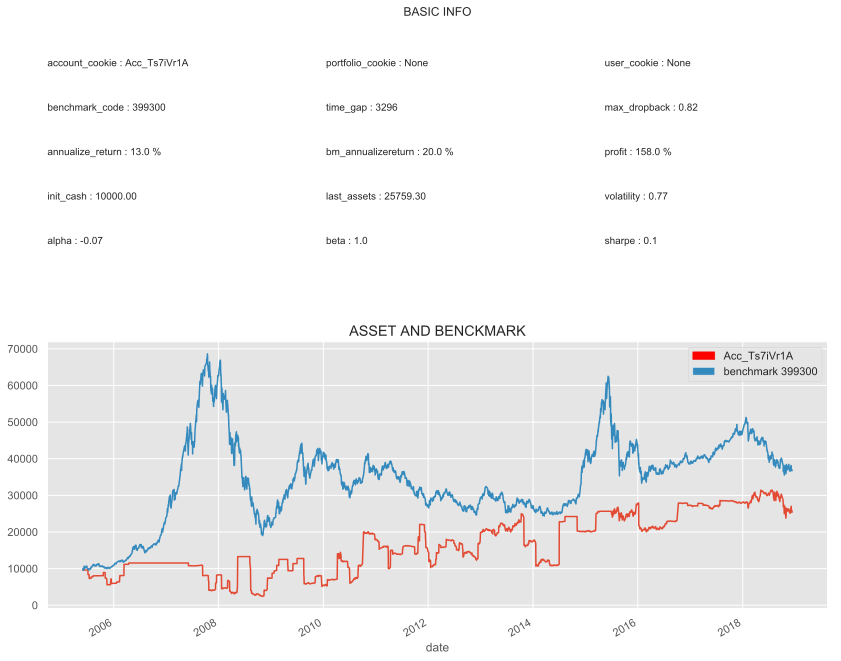

In [13]:
risk.plot_assets_curve()

# 单次购买量逐步增加的测试（每次加100股）

In [14]:
dict_size={}

for size in tqdm_notebook(range(100,600,100)):
    dict_size[size]=_bbands_single(lst,start_str,end_str,amount=size)

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

## Account相关

In [15]:
a=pd.DataFrame(columns=
               ['初始投入','可用资金','现有持仓持有均日期'],
               index=range(100,600,100))

for size in range(100,600,100):
    a.loc[size]['初始投入']=dict_size[size].init_cash
    a.loc[size]['可用资金']=dict_size[size].cash_available
    a.loc[size]['现有持仓持有均日期']=dict_size[size].hold_time().dt.days.mean()
a

,初始投入,可用资金,现有持仓持有均日期
100,10000,1201.3,152.8
200,10000,2918.61,141
300,10000,1278.96,155.25
400,10000,3000.64,245.667
500,10000,4866.45,191


### 当前持仓

In [16]:
for size in range(100, 600, 100):
    pd.DataFrame({'size': size,
                  '': dict_size[size].hold_price(),
                  'time': dict_size[size].hold_time().dt.days})

,,size,time
code,,,
000963,"(28.880000000000006, 200.0)",100,41
000998,"(8.845, 200.0)",100,215
600436,"(92.86, 100.0)",100,167
600867,"(-0.17000000000000454, 100.0)",100,174
600967,"(7.662, 500.0)",100,167


,,size,time
code,,,
000963,"(31.200000000000003, 400.0)",200,41
000998,"(8.845, 400.0)",200,215
600967,"(8.11, 1000.0)",200,167


,,size,time
code,,,
000963,"(31.200000000000006, 600.0)",300,41
000998,"(-4.46, 300.0)",300,215
600801,"(15.31, 300.0)",300,17
600967,"(6.852500000000002, 1200.0)",300,348


,,size,time
code,,,
000998,"(9.610000000000001, 800.0)",400,215
600867,"(5.579999999999997, 400.0)",400,174
600967,"(8.13, 1600.0)",400,348


,,size,time
code,,,
000998,"(10.85, 1000.0)",500,215
600967,"(8.368, 2500.0)",500,167


## Performance相关

In [17]:
#计算期间内指数涨幅
zs_df=QA.QA_fetch_index_day_adv(zs_code,dict_size[100].start_date,dict_size[100].end_date).data
zs_profit=np.round(zs_df.iloc[-1]['close']/zs_df.iloc[0]['close']-1,2)#指数涨幅

In [26]:
p=pd.DataFrame(columns=
               ['总投入','总收益？','收益比？','指数涨幅','胜率',],
               index=range(100,600,100))
for size in range(100,600,100):
    perf=quantaxis_ext.QA_Performance_Ext(dict_size[size])
    p.loc[size]['总投入']=np.round((perf.pnl_fifo_qfq.buy_price * perf.pnl_fifo_qfq.amount).sum(),2)#总投入
    p.loc[size]['总收益？']=np.round(perf.pnl_fifo_qfq.pnl_money_qfq.sum(),2) #n总收益
    p.loc[size]['收益比？']=np.round(perf.pnl_fifo_qfq.pnl_money_qfq.sum()/dict_size[size].init_cash-1,2)
    p.loc[size]['胜率']=perf.win_rate_qfq()
    p.loc[size]['指数涨幅']=zs_profit
p

,总投入,总收益？,收益比？,指数涨幅,胜率
100,243197,27850,1.78,2.69,0.83
200,321360,36386,2.64,2.69,0.83
300,407271,48540,3.85,2.69,0.84
400,393424,48892,3.89,2.69,0.83
500,463430,59395,4.94,2.69,0.83


## Risk相关报表

<module 'matplotlib.pyplot' from 'C:\\Users\\GuQiang\\AppData\\Local\\conda\\conda\\envs\\finance35\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\GuQiang\\AppData\\Local\\conda\\conda\\envs\\finance35\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\GuQiang\\AppData\\Local\\conda\\conda\\envs\\finance35\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\GuQiang\\AppData\\Local\\conda\\conda\\envs\\finance35\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\GuQiang\\AppData\\Local\\conda\\conda\\envs\\finance35\\lib\\site-packages\\matplotlib\\pyplot.py'>

cashhold             利润  利润率 指数涨幅  波动率 当前持仓市值
         max  min mean   利润  利润率 指数涨幅  波动率 当前持仓市值
100      NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN
200      NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN
300      NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN
400      NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN
500      NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN

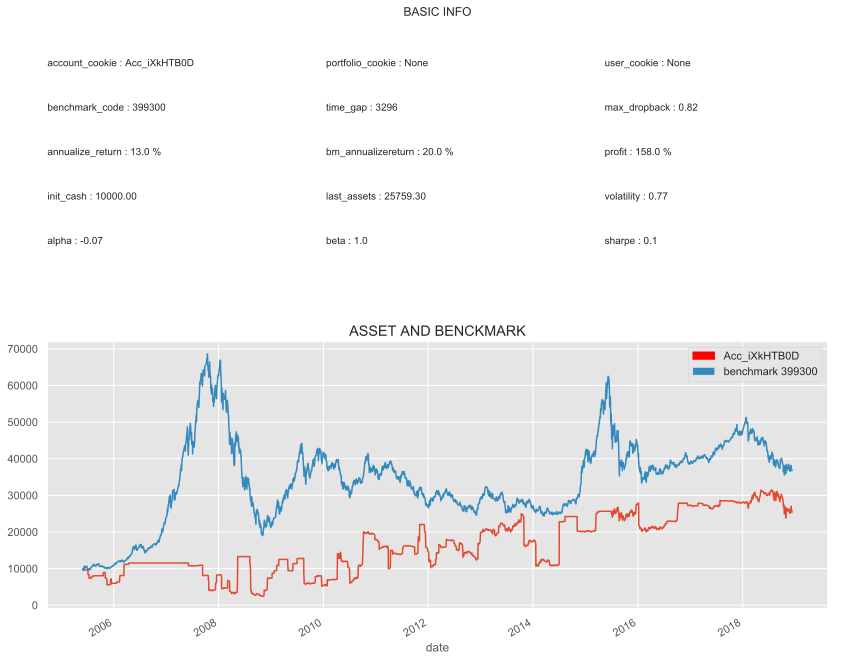

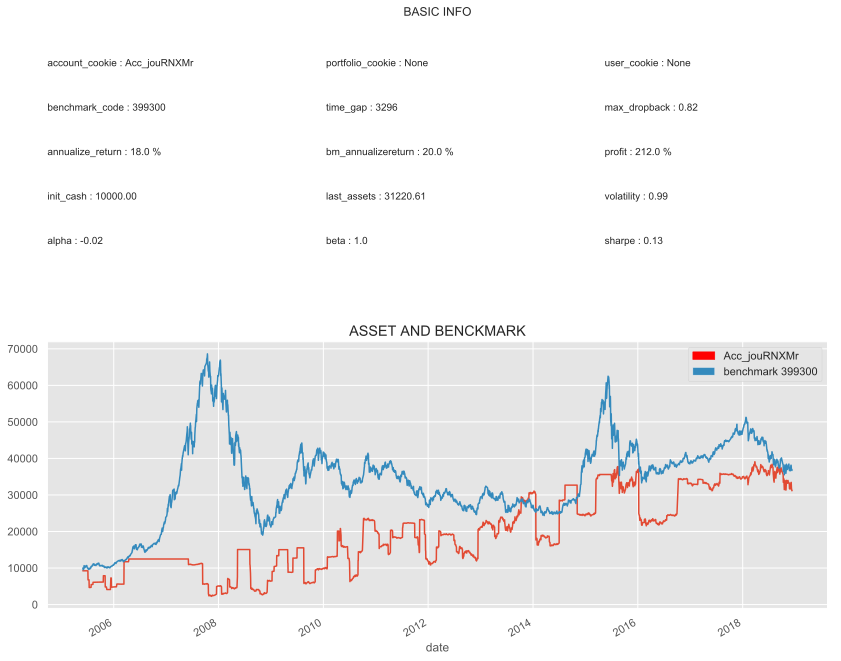

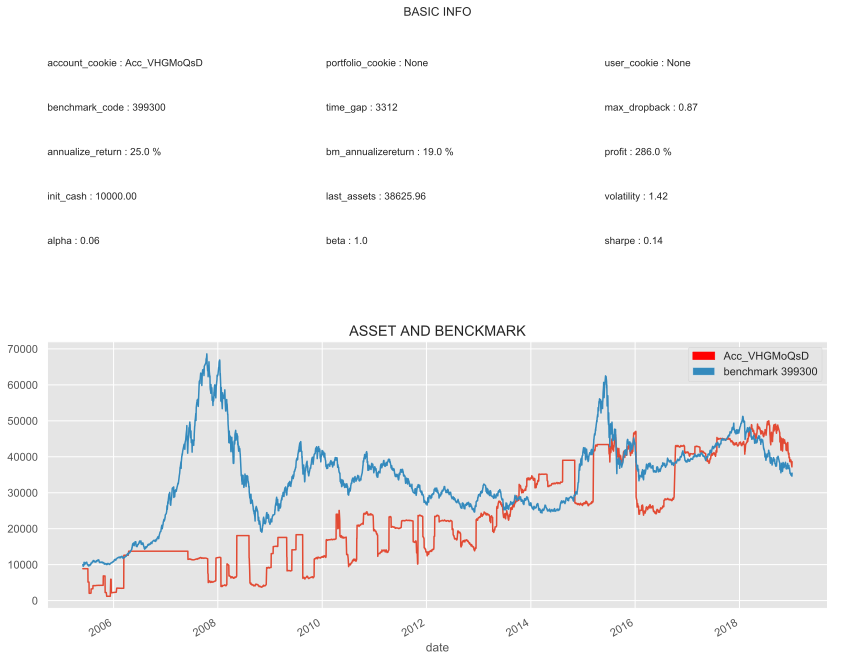

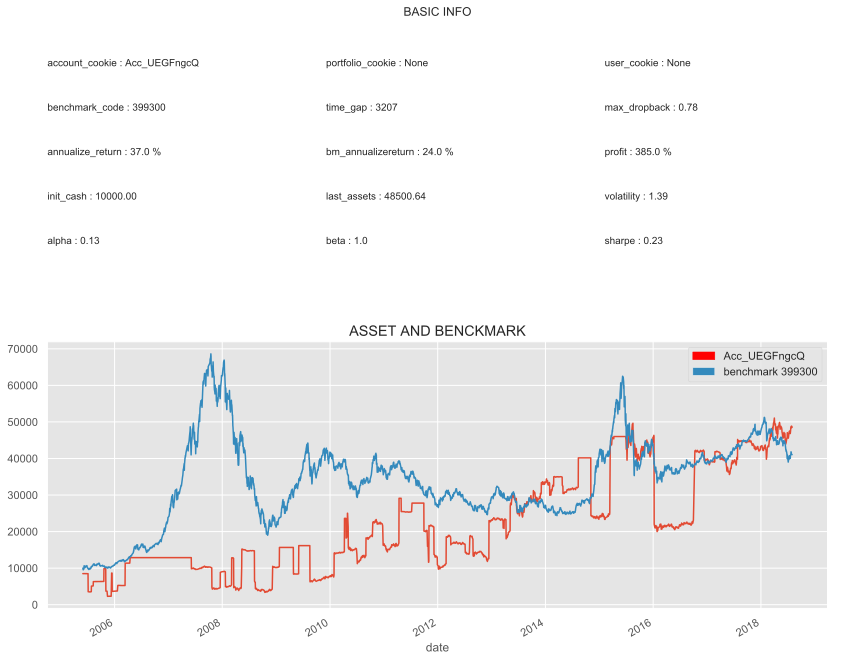

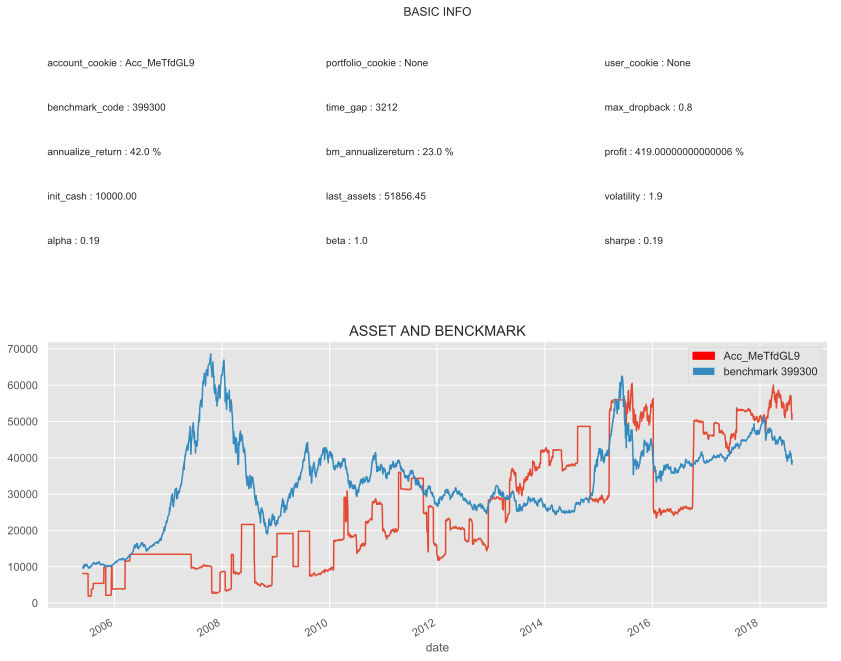

In [61]:
r = pd.DataFrame(
    columns=[[
        'cashhold', 'cashhold', 'cashhold', '利润', '利润率', '指数涨幅', '波动率',
        '当前持仓市值'
    ], ['max', 'min', 'mean', '利润', '利润率', '指数涨幅', '波动率', '当前持仓市值']],
    index=range(100, 600, 100))
for size in range(100, 600, 100):
    risk = quantaxis_ext.QA_Risk_Ext(
        dict_size[size], benchmark_code=jupyter_helper.get_zs_code())
    r.loc[size]['cashhold']['min'] = risk.min_cashhold
    r.loc[size]['cashhold']['max'] = risk.max_cashhold
    r.loc[size]['cashhold']['mean'] = risk.average_cashhold
    r.loc[size]['利润']['利润'] = risk.profit_money
    r.loc[size]['利润率']['利润率'] = risk.profit
    r.loc[size]['波动率']['波动率'] = risk.volatility
#     r.loc[size]['当前持仓市值'] = risk.market_value.iloc[-1].sum()
    
    risk.plot_assets_curve()
r